In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
from libs import vgg16 # Download here! https://github.com/pkmital/CADL/tree/master/session-4/libs

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


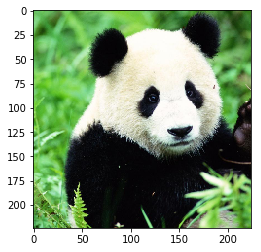

In [2]:
pandaimage = plt.imread('panda.jpg')
pandaimage = vgg16.preprocess(pandaimage)
plt.imshow(pandaimage)

img_4d = np.array([pandaimage])

In [3]:

g = tf.get_default_graph()
input_placeholder = tf.Variable(img_4d,trainable=False)
to_add_image = tf.Variable(tf.random_normal([224,224,3], mean=0.0, stddev=0.1, dtype=tf.float32))
combined_images_not_clamped = input_placeholder+to_add_image

filledmax = tf.fill(tf.shape(combined_images_not_clamped), 1.0)
filledmin = tf.fill(tf.shape(combined_images_not_clamped), 0.0)
greater_than_one = tf.greater(combined_images_not_clamped, filledmax)

combined_images_with_max = tf.where(greater_than_one, filledmax, combined_images_not_clamped)
lower_than_zero =tf.less(combined_images_with_max, filledmin)
combined_images = tf.where(lower_than_zero, filledmin, combined_images_with_max)

net = vgg16.get_vgg_model()
tf.import_graph_def(net['graph_def'], name='vgg')
names = [op.name for op in g.get_operations()]

style_layer = 'prob:0'
the_prediction = tf.import_graph_def(
    net['graph_def'],
    name='vgg',
    input_map={'images:0': combined_images},return_elements=[style_layer])

goldfish_expected_np = np.zeros(1000)
goldfish_expected_np[1]=1.0
goldfish_expected_tf = tf.Variable(goldfish_expected_np,dtype=tf.float32,trainable=False)
loss = tf.reduce_sum(tf.square(the_prediction[0]-goldfish_expected_tf))
optimizer = tf.train.AdamOptimizer().minimize(loss)


In [4]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


In [5]:
def show_many_images(*images):
    fig = plt.figure()
    for i in range(len(images)):
        print(images[i].shape)
        subplot_number = 100+10*len(images)+(i+1)
        plt.subplot(subplot_number)
        plt.imshow(images[i])
    plt.show()

Loss at iteration 1: 1.997808


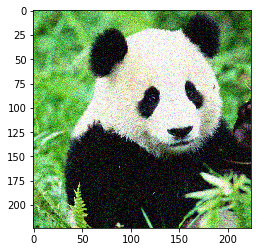

[(716.10535, (388, 'n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca')), (273.27011, (850, 'n04399382 teddy, teddy bear')), (4.1120114, (267, 'n02113799 standard poodle')), (0.95841694, (328, 'n02319095 sea urchin')), (0.92701626, (265, 'n02113624 toy poodle'))]
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


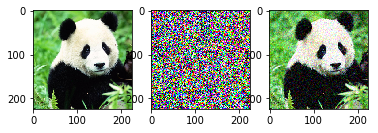

In [ ]:
for i in range(1000):
    _, loss_val = sess.run([optimizer,loss])
   
    if i%100==1:
        print("Loss at iteration %d: %f" % (i,loss_val))
        _, loss_val,adversarial_image,pred,nematode = sess.run([optimizer,loss,combined_images,the_prediction,to_add_image])
        res = np.squeeze(pred)
        average = np.mean(res, 0)
        res = res / np.sum(average)
        plt.imshow(adversarial_image[0])
        plt.show()
        print([(res[idx], net['labels'][idx]) for idx in res.argsort()[-5:][::-1]])
        show_many_images(img_4d[0],nematode,adversarial_image[0])
        plt.imsave('adversarial_goldfish.pdf',adversarial_image[0],format='pdf') # save for printing